In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn as sk


pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

Importing and doing some data exploration

In [2]:
path = '/users/blaizelahman/Desktop/CFB Model/Original Data/Florida_State_model.csv'
modelFSU = pd.read_csv(path)

# throwing out first 20 rows due to missing rolling_sum data
modelFSU = modelFSU.drop(modelFSU.index[:20])
modelFSU = modelFSU.reset_index(drop = True)

modelFSU.info(max_cols = 1000)
modelFSU.Year.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 190 columns):
 #    Column                                 Non-Null Count  Dtype  
---   ------                                 --------------  -----  
 0    Unnamed: 0.1                           188 non-null    int64  
 1    Unnamed: 0                             188 non-null    int64  
 2    Game Id                                188 non-null    int64  
 3    School                                 188 non-null    object 
 4    Conference                             188 non-null    object 
 5    HomeAway                               188 non-null    object 
 6    Points                                 188 non-null    int64  
 7    Week                                   188 non-null    int64  
 8    Year                                   188 non-null    int64  
 9    completionAttempts                     188 non-null    float64
 10   defensiveTDs                           85 non-null     float

2010    13
2012    13
2023    13
2008    12
2009    12
2011    12
2013    12
2014    12
2015    12
2016    12
2017    12
2018    12
2019    12
2021    12
2022    12
2007     5
Name: Year, dtype: int64

Plotting some stats to see linear relationship and distributions

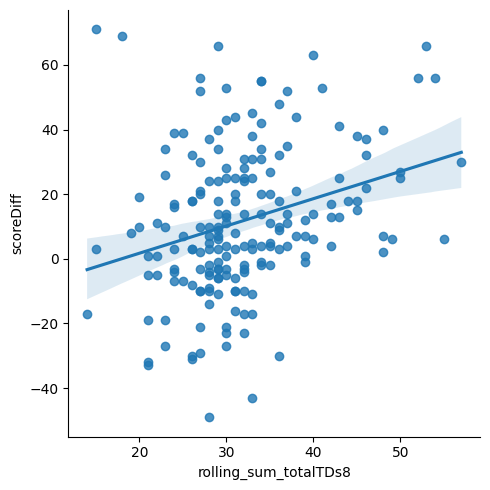

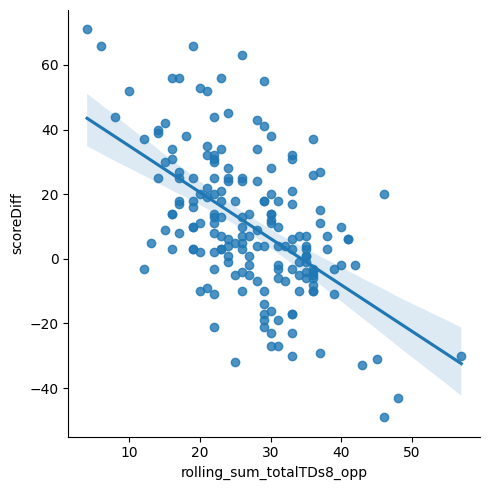

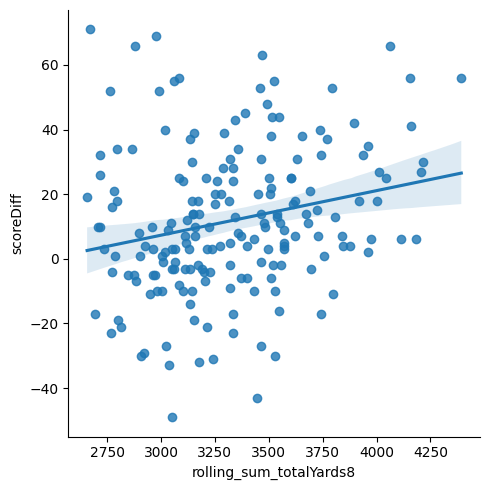

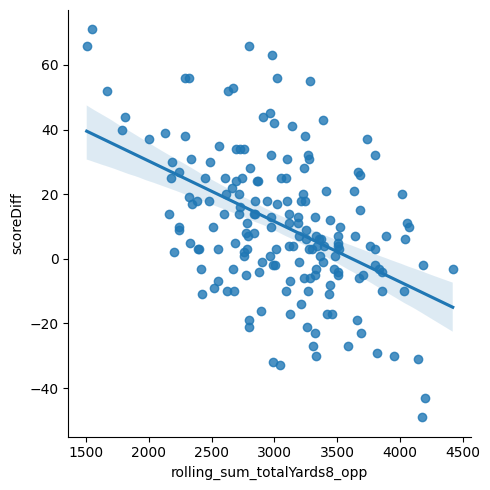

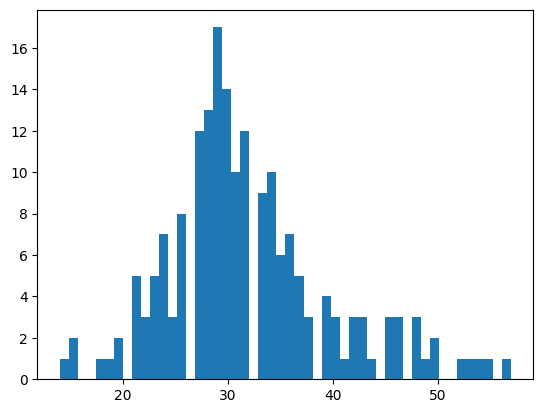

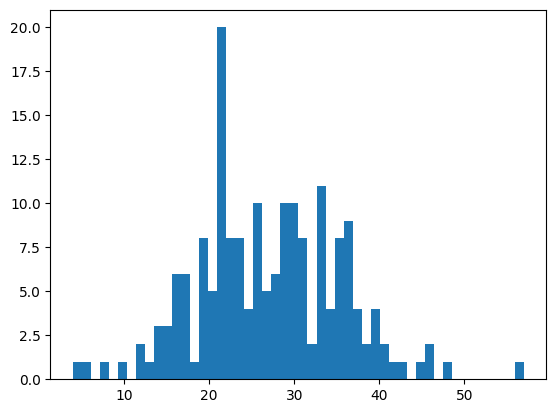

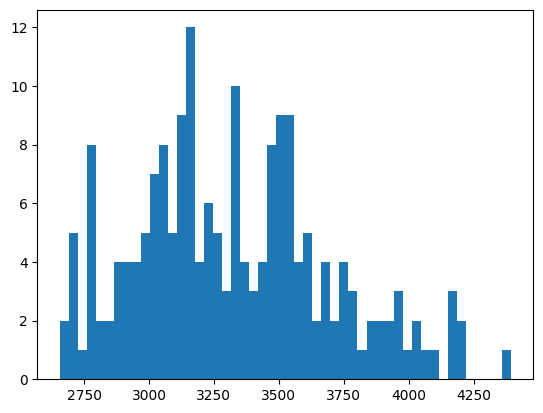

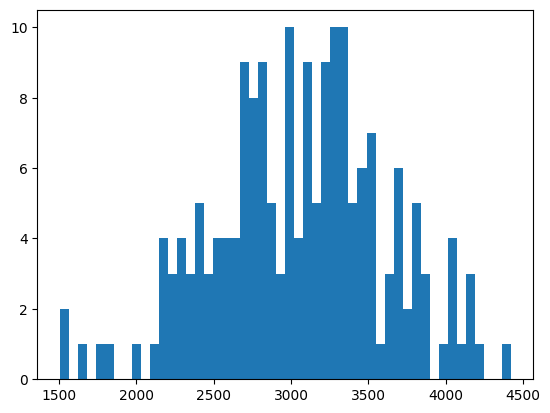

In [3]:
# looking at rolling total touchdowns
sb.lmplot(x = 'rolling_sum_totalTDs8', y = 'scoreDiff', data = modelFSU)
plt.show()

sb.lmplot(x = 'rolling_sum_totalTDs8_opp', y = 'scoreDiff', data = modelFSU)
plt.show()

# looking at rolling total yards
sb.lmplot(x = 'rolling_sum_totalYards8', y = 'scoreDiff', data = modelFSU)
plt.show()

sb.lmplot(x = 'rolling_sum_totalYards8_opp', y = 'scoreDiff', data = modelFSU)
plt.show()

# looking at distributions for stats
plt.hist(modelFSU.rolling_sum_totalTDs8, bins = 50)
plt.show()
plt.hist(modelFSU.rolling_sum_totalTDs8_opp, bins = 50)
plt.show() 
plt.hist(modelFSU.rolling_sum_totalYards8, bins = 50)
plt.show() 
plt.hist(modelFSU.rolling_sum_totalYards8_opp, bins = 50)
plt.show()

Setting up training and testing sets for very basic model

In [4]:
fsuTrain = modelFSU[(modelFSU.Year <= 2022)]
fsuTest = modelFSU[modelFSU.Year == 2023]

In [5]:
xTrain = fsuTrain[['rolling_sum_totalTDs8', 'rolling_sum_totalTDs8_opp', 
              'rolling_sum_totalYards8', 'rolling_sum_totalYards8_opp']].to_numpy()
yTrain = fsuTrain[['scoreDiff']].to_numpy()

xTest = fsuTest[['rolling_sum_totalTDs8', 'rolling_sum_totalTDs8_opp', 
              'rolling_sum_totalYards8', 'rolling_sum_totalYards8_opp']].to_numpy()
yTest = fsuTest[['scoreDiff']].to_numpy()

In [6]:
xTrain.shape, yTrain.shape, xTest.shape, yTest.shape

((175, 4), (175, 1), (13, 4), (13, 1))

Importing and creating pipeline

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

In [8]:
pipe1 = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value = 0)), 
               ('regressor', LinearRegression())])

Creating function for model fitting and output

In [9]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

In [10]:
def fitPrint(pipe, xTrain, yTrain, xTest, yTest):
    
    pipe.fit(xTrain, yTrain)
    trainPreds = pipe.predict(xTrain)
    testPreds = pipe.predict(xTest)
    print('Training error: ' + str(mean_absolute_error(yTrain, trainPreds)))
    print('Test error: ' + str(mean_absolute_error(yTest, testPreds)))

    cvScore = cross_val_score(pipe1, xTrain, yTrain, cv = 5, scoring = 'neg_mean_absolute_error')
    print('Mean MAE from cross-validation:', -cvScore.mean())

    coef = pipe.named_steps['regressor'].coef_
    print('Coefficients:', coef)

In [11]:
fitPrint(pipe1, xTrain, yTrain, xTest, yTest)

Training error: 13.751466286373876
Test error: 13.537430902501294
Mean MAE from cross-validation: 14.081425869532472
Coefficients: [[ 9.22858420e-01 -1.34930713e+00 -1.20251764e-03 -7.40231292e-04]]


Not bad but the predictors are not representative enough of the data set, we need to select from all of the predictors available

Selecting more predictors to improve model

In [12]:
from sklearn.feature_selection import SequentialFeatureSelector

In [13]:
rollingCols = [col for col in modelFSU.columns if 'rolling_sum' in col]

Creating SFS, selecting amount of features we want, and adding it to the pipeline

In [14]:
lr = LinearRegression()
sfs = SequentialFeatureSelector(lr, n_features_to_select = 6, direction = 'forward')

In [15]:
xTrain = fsuTrain[rollingCols].to_numpy()
yTrain = fsuTrain[['scoreDiff']].to_numpy()

xTest = fsuTest[rollingCols].to_numpy()
yTest = fsuTest[['scoreDiff']].to_numpy()

In [16]:
pipe2 = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value = 0)), 
                ('feature_selector', sfs),
                ('regressor', LinearRegression())])

Updating fitPrint to output the selected features from the SequentialFeatureSelector

In [17]:
def fitPrint(pipe, xTrain, yTrain, xTest, yTest):

    # fittng the model and getting predictions
    pipe.fit(xTrain, yTrain)
    trainPreds = pipe.predict(xTrain)
    testPreds = pipe.predict(xTest)
        
    # getting MAE from model
    print('Training error: ' + str(mean_absolute_error(yTrain, trainPreds)))
    print('Test error: ' + str(mean_absolute_error(yTest, testPreds)))

    # using cross-validation to get average MAE
    cvScore = cross_val_score(pipe, xTrain, yTrain, cv = 5, scoring = 'neg_mean_absolute_error')
    print('Mean MAE from cross-validation:', -cvScore.mean())

    # getting selected features from SFS
    sfs = pipe.named_steps['feature_selector']
    selectedFeatures = sfs.get_support()
    selectedFeatureNames = [rollingCols[i] for i, selected in enumerate(selectedFeatures) if selected]

    regressor = pipe.named_steps['regressor']

    # outputting each selected feature with their coefficient
    for i in range(len(selectedFeatureNames)):
        feature = selectedFeatureNames[i]
        coefficient = regressor.coef_[0][i]
        print(f'{feature}: {coefficient}')
        


In [18]:
fitPrint(pipe2, xTrain, yTrain, xTest, yTest)

Training error: 12.554421637233443
Test error: 12.837724904530416
Mean MAE from cross-validation: 13.263673907986776
rolling_sum_yardsPerPass20: 3.116435237931509
rolling_sum_fumblesLost8: -0.5722795287499806
rolling_sum_totalTDs8: 0.3791134514732162
rolling_sum_Points8_opp: -0.14245326544364464
rolling_sum_puntReturns8_opp: -0.7060460555322549
rolling_sum_qbHurries8_opp: -0.3843501740114335


Model is slightly improved but still isn't very good, need to enhance model with better data and modeling techniques 